## Coursera Applied Data Science 'The Battle of Neighborhoods' Capstone Project Notebook

Calgary Real Estate Assistant



Import Libraries

In [1]:
import pandas as pd
import numpy as np

import geopy
from IPython.core.display import Image
from geopy.geocoders import Nominatim

import requests

from pandas.io.json import json_normalize

import folium

import seaborn as sns

from matplotlib import pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans


In [2]:
# Read in our data

df_values = pd.read_csv('property_values.csv')



In [3]:
# Print top 5 rows 

df_values.head()

Neighborhood     Value   LATITUDE   LONGITUDE
0                     ABBEYDALE  300000.0  51.058941 -113.929649
1                        ACADIA  405500.0  50.972799 -114.058883
2  ALBERT PARK/RADISSON HEIGHTS  310000.0  51.041720 -113.995064
3                      ALTADORE  775250.0  51.018423 -114.104126
4                APPLEWOOD PARK  347250.0  51.043497 -113.927941

Visualize all neighborhoods on the map of Calgary




In [4]:
# Calgary's lat/long information
latitude = 51.0447
longitude = -114.0719

# Base Map
map_calgary_neighborhoods = folium.Map(location=[latitude, longitude], zoom_start=10, tiles='OpenStreetMap')

for lat, lng, label in zip(df_values['LATITUDE'],
                           df_values['LONGITUDE'],
                           df_values['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_opacity= 0.8,
        parse_html=False).add_to(map_calgary_neighborhoods)

map_calgary_neighborhoods


Define Foursquare credentials, version, limit and radius

In [5]:
CLIENT_ID = 'REMOVED'
CLIENT_SECRET = 'REMOVED'
VERSION = '20180605'
LIMIT = 200
radius = 500

Function getNearbyVenues borrowed from the lab


In [6]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Apply function to our data set

In [7]:
#calgary_venues = getNearbyVenues(names=df_values['Neighborhood'],
 #                                latitudes=df_values['LATITUDE'],
 #                                longitudes=df_values['LONGITUDE'])

# save as a csv to avoid rate limit on API
#calgary_venues.to_csv('foursquare_info.csv')
calgary_venues = pd.read_csv('foursquare_info.csv')
calgary_venues.drop(columns='Unnamed: 0', inplace=True)

In [8]:
# Check the data

calgary_venues.head()



Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    ABBEYDALE              51.058941             -113.929649   
1    ABBEYDALE              51.058941             -113.929649   
2    ABBEYDALE              51.058941             -113.929649   
3    ABBEYDALE              51.058941             -113.929649   
4       ACADIA              50.972799             -114.058883   

                             Venue  Venue Latitude  Venue Longitude  \
0                           Subway       51.059239      -113.934423   
1                            Mac's       51.059376      -113.934425   
2                     roadside pub       51.059277      -113.934529   
3                           Redbox       51.059108      -113.934845   
4  Acadia Aquatic & Fitness Centre       50.973297      -114.059984   

         Venue Category  
0        Sandwich Place  
1     Convenience Store  
2           Wings Joint  
3           Pizza Place  
4  Gym / Fitness Center

Exploratory data analysis of venues in Calgary

In [9]:
def draw_map(data, zoom_para):
    
    # Base map
    map_calgary = folium.Map(location=[latitude, longitude], zoom_start=zoom_para, tiles='OpenStreetMap')
    
    for lat, lng, label, nb in zip(calgary_venues['Venue Latitude'],
                            calgary_venues['Venue Longitude'],
                            calgary_venues['Venue'],
                            calgary_venues['Neighborhood']):
        label = folium.Popup(str(label)+', '+str(nb), parse_html=True)
        
        folium.CircleMarker(
            [lat, lng],
            radius = 5,
            popup = label,
            color = 'blue',
            fill= True,
            fill_opacity = 0.8,
            parse_html=False).add_to(map_calgary)
        
    return(map_calgary)

In [10]:
# Draw map using venue data

draw_map(calgary_venues, 12)


Check how many venues were returned for each neighborhood


In [11]:
# Group by and count the number of venues within each neighborhood

calgary_venues_count_list = calgary_venues.groupby('Neighborhood')['Venue'].count().to_frame()



In [12]:
# Show top 5 neighborhoods that have most venues

calgary_venues_count_list.sort_values(by=['Venue'], ascending=False).head()



Venue
Neighborhood            
LOWER MOUNT ROYAL     57
BELTLINE              51
MEADOWLARK PARK       50
CLIFF BUNGALOW        40
MANCHESTER            38

In [13]:
# Show bottom 5 neighborhoods for venue count

calgary_venues_count_list.sort_values(by=['Venue'], ascending=False).tail()

Venue
Neighborhood       
DIAMOND COVE      1
CORNERSTONE       1
SHERWOOD          1
SHAWNESSY         1
SAGE HILL         1

In [14]:
# Let's visualize parks in Calgary

draw_map(calgary_venues[calgary_venues['Venue Category'] == 'Park'], 11)

List all potential venues for each neighborhood

In [15]:
# We'll create dummy variables based on Venue Category for each row in calgary_venues dataframe

#One hot encoding
calgary_onehot = pd.get_dummies(calgary_venues['Venue Category'], prefix='', prefix_sep='')

# Add neighborhood column to onehot dataframe
calgary_onehot['Neighborhood'] = calgary_venues['Neighborhood']

# Move neighborhood column to first column
fixed_columns = [calgary_onehot.columns[-1]] + list(calgary_onehot.columns[:-1])
calgary_onehot = calgary_onehot[fixed_columns]

# Check number of rows
print("The shape of the dataframe is {}. The dataset has {} rows.".format(
    calgary_onehot.shape, calgary_onehot.shape[0]))

# View top 5 rows

calgary_onehot.head()

The shape of the dataframe is (1300, 217). The dataset has 1300 rows.


Yoga Studio  Accessories Store  American Restaurant  \
0            0                  0                    0   
1            0                  0                    0   
2            0                  0                    0   
3            0                  0                    0   
4            0                  0                    0   

   Argentinian Restaurant  Arts & Crafts Store  Asian Restaurant  Astrologer  \
0                       0                    0                 0           0   
1                       0                    0                 0           0   
2                       0                    0                 0           0   
3                       0                    0                 0           0   
4                       0                    0                 0           0   

   Athletics & Sports  Auto Workshop  BBQ Joint  ...  Train Station  \
0                   0              0          0  ...              0   
1                   0              0          0  ...              0   
2                   0              0          0  ...              0   
3                   0              0          0  ...              0   
4                   0              0          0  ...              0   

   Vegetarian / Vegan Restaurant  Video Game Store  Video Store  \
0                              0                 0            0   
1                              0                 0            0   
2                              0                 0            0   
3                              0                 0            0   
4                              0                 0            0   

   Vietnamese Restaurant  Waterfall  Wine Bar  Wine Shop  Wings Joint  \
0                      0          0         0          0            0   
1                      0          0         0          0            0   
2                      0          0         0          0            1   
3                      0          0         0          0            0   
4                      0          0         0          0            0   

   Women's Store  
0              0  
1              0  
2              0  
3              0  
4              0  

[5 rows x 217 columns]

Group rows by neighborhood to generate relative frequency




In [16]:
# Group by
calgary_grouped = calgary_onehot.groupby('Neighborhood').mean().reset_index()

# Check the shape of our data
print('The shape of the dataframe is {}. the dataset has {} rows.'.format(calgary_grouped.shape, calgary_grouped.shape[0]))

# Print top 5 rows
calgary_grouped.head()


The shape of the dataframe is (188, 217). the dataset has 188 rows.


Neighborhood  Yoga Studio  Accessories Store  \
0                     ABBEYDALE          0.0                0.0   
1                        ACADIA          0.0                0.0   
2  ALBERT PARK/RADISSON HEIGHTS          0.0                0.0   
3                      ALTADORE          0.0                0.0   
4                APPLEWOOD PARK          0.0                0.0   

   American Restaurant  Argentinian Restaurant  Arts & Crafts Store  \
0                  0.0                     0.0                  0.0   
1                  0.0                     0.0                  0.0   
2                  0.0                     0.0                  0.0   
3                  0.0                     0.0                  0.0   
4                  0.0                     0.0                  0.0   

   Asian Restaurant  Astrologer  Athletics & Sports  Auto Workshop  ...  \
0               0.0         0.0                 0.0            0.0  ...   
1               0.0         0.0                 0.0            0.0  ...   
2               0.0         0.0                 0.0            0.0  ...   
3               0.0         0.0                 0.0            0.0  ...   
4               0.0         0.0                 0.0            0.0  ...   

   Train Station  Vegetarian / Vegan Restaurant  Video Game Store  \
0            0.0                            0.0               0.0   
1            0.0                            0.0               0.0   
2            0.0                            0.0               0.0   
3            0.0                            0.0               0.0   
4            0.0                            0.0               0.0   

   Video Store  Vietnamese Restaurant  Waterfall  Wine Bar  Wine Shop  \
0          0.0                   0.00        0.0       0.0        0.0   
1          0.0                   0.00        0.0       0.0        0.0   
2          0.0                   0.25        0.0       0.0        0.0   
3          0.0                   0.00        0.0       0.0        0.0   
4          0.0                   0.20        0.0       0.0        0.0   

   Wings Joint  Women's Store  
0         0.25            0.0  
1         0.00            0.0  
2         0.00            0.0  
3         0.00            0.0  
4         0.00            0.0  

[5 rows x 217 columns]

Prepare our dataset for clustering


In [17]:
# Merge venues data with economic data

calgary_grouped_econ = pd.merge(calgary_grouped, df_values, how='left', on='Neighborhood')


# Let's take a look at the dataframe
calgary_grouped_econ.head()


Neighborhood  Yoga Studio  Accessories Store  \
0                     ABBEYDALE          0.0                0.0   
1                        ACADIA          0.0                0.0   
2  ALBERT PARK/RADISSON HEIGHTS          0.0                0.0   
3                      ALTADORE          0.0                0.0   
4                APPLEWOOD PARK          0.0                0.0   

   American Restaurant  Argentinian Restaurant  Arts & Crafts Store  \
0                  0.0                     0.0                  0.0   
1                  0.0                     0.0                  0.0   
2                  0.0                     0.0                  0.0   
3                  0.0                     0.0                  0.0   
4                  0.0                     0.0                  0.0   

   Asian Restaurant  Astrologer  Athletics & Sports  Auto Workshop  ...  \
0               0.0         0.0                 0.0            0.0  ...   
1               0.0         0.0                 0.0            0.0  ...   
2               0.0         0.0                 0.0            0.0  ...   
3               0.0         0.0                 0.0            0.0  ...   
4               0.0         0.0                 0.0            0.0  ...   

   Video Store  Vietnamese Restaurant  Waterfall  Wine Bar  Wine Shop  \
0          0.0                   0.00        0.0       0.0        0.0   
1          0.0                   0.00        0.0       0.0        0.0   
2          0.0                   0.25        0.0       0.0        0.0   
3          0.0                   0.00        0.0       0.0        0.0   
4          0.0                   0.20        0.0       0.0        0.0   

   Wings Joint  Women's Store     Value   LATITUDE   LONGITUDE  
0         0.25            0.0  300000.0  51.058941 -113.929649  
1         0.00            0.0  405500.0  50.972799 -114.058883  
2         0.00            0.0  310000.0  51.041720 -113.995064  
3         0.00            0.0  775250.0  51.018423 -114.104126  
4         0.00            0.0  347250.0  51.043497 -113.927941  

[5 rows x 220 columns]

In [18]:
# Drop all text columns, to prepare for clustering

calgary_grouped_clustering = calgary_grouped_econ.drop(['Neighborhood'], axis=1)

# All columns in calgary_grouped clustering are numeric

Define dependent variable and independent variables




In [19]:
y = calgary_grouped_clustering['Value']
X = calgary_grouped_clustering.loc[:, calgary_grouped_clustering.columns != 'Value']


Draw Elbow Curve to find the optimal number of clusters

Text(0.5, 1.0, 'Elbow Curve')

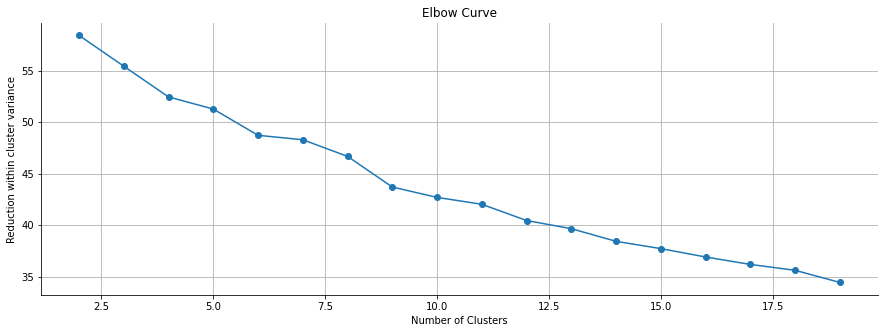

In [20]:
within_cluster_variance = []

for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    within_cluster_variance.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), within_cluster_variance, marker='o')
plt.grid(True)
plt.xlabel('Number of Clusters')
plt.ylabel('Reduction within cluster variance')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Elbow Curve')


C:\Users\jyana\Documents\Coursera\Coursera_Capstone\venv\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\jyana\Documents\Coursera\Coursera_Capstone\venv\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


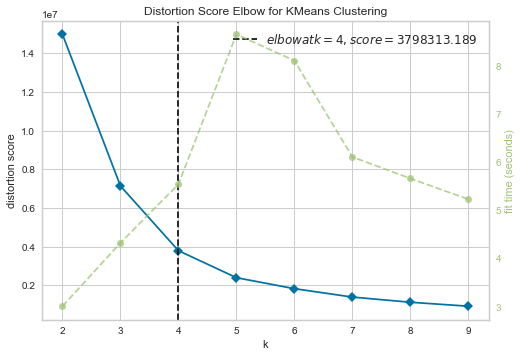

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x00000288D43460B8>,
                 k=None, model=None)

In [21]:
# Looking at our elbow curve, we don't see a very good optimal clusters, lets another method

from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.datasets.loaders import load_nfl

X, y = load_nfl()

kelbow_visualizer(KMeans(random_state=4), X, k=(2, 10))





In [22]:
# That's better, looks like 4 clusters will be optimal

# Let's initiate clustering

kmeans = KMeans(n_clusters=4)

# Fit the data

kmeans.fit(calgary_grouped_clustering)

# Generate Cluster

y_kmeans = kmeans.predict(calgary_grouped_clustering)

# Attach cluster label to calgary_grouped_econ. Now all neighborhoods have certain clusters assigned
calgary_grouped_econ['Cluster'] = y_kmeans

In [23]:
# Let's sort venues for each neighborhood in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)

    return row_categories_sorted.index.values[0:num_top_venues]

In [24]:
# Let's make a new dataframe with top 6 venues in each neighborhood

num_top_venues = 6

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns = columns)
neighborhoods_venues_sorted['Neighborhood'] = calgary_grouped['Neighborhood']

for ind in np.arange(calgary_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(calgary_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0                     ABBEYDALE           Wings Joint           Pizza Place   
1                        ACADIA     Recreation Center  Gym / Fitness Center   
2  ALBERT PARK/RADISSON HEIGHTS                  Bank           Bus Station   
3                      ALTADORE                   Pub               Brewery   
4                APPLEWOOD PARK                  Park          Liquor Store   

   3rd Most Common Venue 4th Most Common Venue        5th Most Common Venue  \
0      Convenience Store        Sandwich Place  Eastern European Restaurant   
1          Women's Store                  Food                    Gastropub   
2  Vietnamese Restaurant           Pizza Place            Food & Drink Shop   
3         Ice Cream Shop        Massage Studio            Food & Drink Shop   
4  Vietnamese Restaurant           Pizza Place                Women's Store   

  6th Most Common Venue  
0     Food & Drink Shop  
1           Gas Station  
2             Gift Shop  
3             Gift Shop  
4             Gastropub

In [25]:
# Merge sorted venues dataframe with economic, geographic data

neighborhoods_venues_sorted.insert(0, 'Cluster', y_kmeans)

calgary_top_merged = pd.merge(neighborhoods_venues_sorted, df_values[['Neighborhood', 'LATITUDE', 'LONGITUDE', 'Value']], how='left')

calgary_top_merged.head()

Cluster                  Neighborhood 1st Most Common Venue  \
0        2                     ABBEYDALE           Wings Joint   
1        0                        ACADIA     Recreation Center   
2        2  ALBERT PARK/RADISSON HEIGHTS                  Bank   
3        3                      ALTADORE                   Pub   
4        2                APPLEWOOD PARK                  Park   

  2nd Most Common Venue  3rd Most Common Venue 4th Most Common Venue  \
0           Pizza Place      Convenience Store        Sandwich Place   
1  Gym / Fitness Center          Women's Store                  Food   
2           Bus Station  Vietnamese Restaurant           Pizza Place   
3               Brewery         Ice Cream Shop        Massage Studio   
4          Liquor Store  Vietnamese Restaurant           Pizza Place   

         5th Most Common Venue 6th Most Common Venue   LATITUDE   LONGITUDE  \
0  Eastern European Restaurant     Food & Drink Shop  51.058941 -113.929649   
1                    Gastropub           Gas Station  50.972799 -114.058883   
2            Food & Drink Shop             Gift Shop  51.041720 -113.995064   
3            Food & Drink Shop             Gift Shop  51.018423 -114.104126   
4                Women's Store             Gastropub  51.043497 -113.927941   

      Value  
0  300000.0  
1  405500.0  
2  310000.0  
3  775250.0  
4  347250.0

Merge Neighborhood geographic data into calgary_grouped_econ


In [26]:
# Left join

calgary_merged = pd.merge(calgary_grouped_econ, df_values[['Neighborhood', 'LATITUDE', 'LONGITUDE']], how='left')

# View the final dataset
calgary_merged.head()

Neighborhood  Yoga Studio  Accessories Store  \
0                     ABBEYDALE          0.0                0.0   
1                        ACADIA          0.0                0.0   
2  ALBERT PARK/RADISSON HEIGHTS          0.0                0.0   
3                      ALTADORE          0.0                0.0   
4                APPLEWOOD PARK          0.0                0.0   

   American Restaurant  Argentinian Restaurant  Arts & Crafts Store  \
0                  0.0                     0.0                  0.0   
1                  0.0                     0.0                  0.0   
2                  0.0                     0.0                  0.0   
3                  0.0                     0.0                  0.0   
4                  0.0                     0.0                  0.0   

   Asian Restaurant  Astrologer  Athletics & Sports  Auto Workshop  ...  \
0               0.0         0.0                 0.0            0.0  ...   
1               0.0         0.0                 0.0            0.0  ...   
2               0.0         0.0                 0.0            0.0  ...   
3               0.0         0.0                 0.0            0.0  ...   
4               0.0         0.0                 0.0            0.0  ...   

   Vietnamese Restaurant  Waterfall  Wine Bar  Wine Shop  Wings Joint  \
0                   0.00        0.0       0.0        0.0         0.25   
1                   0.00        0.0       0.0        0.0         0.00   
2                   0.25        0.0       0.0        0.0         0.00   
3                   0.00        0.0       0.0        0.0         0.00   
4                   0.20        0.0       0.0        0.0         0.00   

   Women's Store     Value   LATITUDE   LONGITUDE  Cluster  
0            0.0  300000.0  51.058941 -113.929649        2  
1            0.0  405500.0  50.972799 -114.058883        0  
2            0.0  310000.0  51.041720 -113.995064        2  
3            0.0  775250.0  51.018423 -114.104126        3  
4            0.0  347250.0  51.043497 -113.927941        2  

[5 rows x 221 columns]

Exploratory data analysis of clustered neighborhoods in Calgary


In [27]:

# Visualize clustered neighborhoods in Calgary

map_clusters = folium.Map(location=[latitude, longitude], zoom_start = 10)

kclusters = 4

# set color scheme for clusters
j = np.arange(kclusters)
ys = [i + j + (i*j)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
marker_colors = []
for lat, lng, nb, cluster in zip(calgary_merged['LATITUDE'], calgary_merged['LONGITUDE'], calgary_merged['Neighborhood'], calgary_merged['Cluster']):
    label = folium.Popup(str(nb) + ' / Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = rainbow[cluster-1],
        fill = True,
        fill_color = rainbow[cluster-1],
        fill_opacity = 1).add_to(map_clusters)
map_clusters

Statistics of each Cluster

In [28]:
# Define a function to return statistics of each cluster

def statistics(calgary_top_merged, num):
    print('Average home value of this cluster is: {:.1f}'.format(calgary_top_merged[calgary_top_merged['Cluster']==num]['Value'].mean(axis=0)))
    return calgary_top_merged[calgary_top_merged['Cluster']==num][['Neighborhood', '1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue']]

In [29]:
# lets look at cluster 0
statistics(calgary_top_merged, 0)

Average home value of this cluster is: 470603.7


Neighborhood       1st Most Common Venue  \
1                       ACADIA           Recreation Center   
5                  ARBOUR LAKE               Moving Target   
7                   AUBURN BAY           Other Repair Shop   
15             BONAVISTA DOWNS              Baseball Field   
16                     BOWNESS                         Pub   
..                         ...                         ...   
176                    VARSITY               Grocery Store   
182                WILLOW PARK        Gym / Fitness Center   
184  WINSTON HEIGHTS/MOUNTVIEW          Italian Restaurant   
185                   WOODBINE  Construction & Landscaping   
186                  WOODLANDS           Food & Drink Shop   

      2nd Most Common Venue 3rd Most Common Venue  
1      Gym / Fitness Center         Women's Store  
5             Grocery Store         Shopping Mall  
7          Basketball Court         Women's Store  
15   Furniture / Home Store    Chinese Restaurant  
16              Coffee Shop                  Café  
..                      ...                   ...  
176               Wine Shop           Gas Station  
182                    Bank         Women's Store  
184       Convenience Store         Grocery Store  
185             Music Venue         Women's Store  
186                     Pub          Liquor Store  

[82 rows x 4 columns]

In [30]:
# cluster 1
statistics(calgary_top_merged, 1)


Average home value of this cluster is: 1422142.9


Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
12            BEL-AIRE        Clothing Store        Scenic Lookout   
21           BRITANNIA           Coffee Shop                  Park   
56         EAGLE RIDGE        Sandwich Place                  Pier   
59          ELBOW PARK   Japanese Restaurant     Health Food Store   
101            MAYFAIR        Clothing Store        Scenic Lookout   
141            ROXBORO                   Bar                  Café   
174  UPPER MOUNT ROYAL           Coffee Shop         Grocery Store   

    3rd Most Common Venue  
12          Women's Store  
21         Ice Cream Shop  
56                 Museum  
59      Food & Drink Shop  
101         Women's Store  
141     Indian Restaurant  
174     Convenience Store

In [31]:
# cluster 2
statistics(calgary_top_merged, 2)

Average home value of this cluster is: 293291.1


Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0                       ABBEYDALE           Wings Joint           Pizza Place   
2    ALBERT PARK/RADISSON HEIGHTS                  Bank           Bus Station   
4                  APPLEWOOD PARK                  Park          Liquor Store   
9                        BANKVIEW           Pizza Place           Coffee Shop   
11             BEDDINGTON HEIGHTS               Theater                   Pub   
..                            ...                   ...                   ...   
169                        TEMPLE          Home Service      Business Service   
177                 VISTA HEIGHTS       Thai Restaurant               Brewery   
180                     WHITEHORN           Gas Station           Pizza Place   
183                  WINDSOR PARK    Italian Restaurant        Clothing Store   
187                     YORKVILLE          Liquor Store         Grocery Store   

          3rd Most Common Venue  
0             Convenience Store  
2         Vietnamese Restaurant  
4         Vietnamese Restaurant  
9             Indian Restaurant  
11                 Skating Rink  
..                          ...  
169  Construction & Landscaping  
177                       Hotel  
180                   Pet Store  
183                 Coffee Shop  
187                         Bar  

[73 rows x 4 columns]

In [32]:
# cluster 3
statistics(calgary_top_merged, 3)

Average home value of this cluster is: 723403.8


Neighborhood       1st Most Common Venue  2nd Most Common Venue  \
3                 ALTADORE                         Pub                Brewery   
6              ASPEN WOODS               Grocery Store            Coffee Shop   
8              BANFF TRAIL                 Coffee Shop             Steakhouse   
10                 BAYVIEW                         Pub         Breakfast Spot   
27             CHARLESWOOD           Elementary School          Women's Store   
29            CHINOOK PARK                         Pub      Accessories Store   
30           CHRISTIE PARK                        Park         Massage Studio   
60                  ELBOYA                  Smoke Shop  Vietnamese Restaurant   
74                HAMPTONS                        Park          Women's Store   
85            KELVIN GROVE           Convenience Store          Women's Store   
90                LAKEVIEW                         Spa                   Park   
105        MEADOWLARK PARK              Clothing Store      Electronics Store   
111         MOUNT PLEASANT           Korean Restaurant   Fast Food Restaurant   
114    NORTH GLENMORE PARK           Food & Drink Shop            Golf Course   
121               PARKDALE              Ice Cream Shop     Chinese Restaurant   
134               RICHMOND                  Playground            Pizza Place   
138               ROSEDALE                  Comic Shop            Coffee Shop   
139               ROSEMONT                     Dog Run           Cocktail Bar   
147               SCARBORO               Deli / Bodega             Playground   
148  SCARBORO/SUNALTA WEST                Gourmet Shop            Record Shop   
163    ST. ANDREWS HEIGHTS  Construction & Landscaping                   Café   
164        STRATHCONA PARK               Grocery Store               Building   
173     UNIVERSITY HEIGHTS                         Pub         Sandwich Place   
178         WEST HILLHURST          Italian Restaurant         Ice Cream Shop   
179           WEST SPRINGS                 Coffee Shop               Pharmacy   
181               WILDWOOD                 Pizza Place          Women's Store   

    3rd Most Common Venue  
3          Ice Cream Shop  
6                Pharmacy  
8             High School  
10          Grocery Store  
27      Food & Drink Shop  
29    Japanese Restaurant  
30      Food & Drink Shop  
60             Restaurant  
74              Gift Shop  
85      Food & Drink Shop  
90                Dog Run  
105           Coffee Shop  
111     Convenience Store  
114        Breakfast Spot  
121                School  
134           Music Store  
138    Chinese Restaurant  
139                  Park  
147           Pizza Place  
148         Grocery Store  
163           Pizza Place  
164         Women's Store  
173             BBQ Joint  
178        Breakfast Spot  
179          Liquor Store  
181                  Food

In [34]:

# Function to Return Neighborhoods that have venues in top venue list and value is at or below budget

# Setup Parameters
# Our client in this example has a budget of $800,000
# Our client is looking for a neighborhood with plenty of Coffee Shops, and Pubs.

venue1 = ["Coffee Shop"]
venue2 = ['Pub']
budget = 400000

# Function search_data_frame
# Takes budget, dataframe, all the venues you'd like and searches for neighborhoods that meet the criteria
def search_data_frame(amount, data, *venues):
        venue_df = data

        for venue in venues:
            venue_query = venue_df.isin(venue).any(axis=1)
            venue_df = venue_df[venue_query]

        search_query = venue_df[venue_df['Value'] <= amount]
        return search_query

# Run our functions with the parameters we set
search_venues = search_data_frame(budget, calgary_top_merged, venue1, venue2)

# Let's take a look
search_venues.head()


Cluster       Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
16         0            BOWNESS                   Pub           Coffee Shop   
55         2  DOWNTOWN WEST END           Coffee Shop        Sandwich Place   
107        2           MILLRISE                   Pub                  Bank   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
16                   Café               Stadium     Food & Drink Shop   
55     Light Rail Station                   Pub             Nightclub   
107           Pizza Place           Coffee Shop           Golf Course   

           6th Most Common Venue   LATITUDE   LONGITUDE     Value  
16   Eastern European Restaurant  51.088532 -114.196535  383500.0  
55                      Pharmacy  51.047856 -114.086675  199250.0  
107                Grocery Store  50.916793 -114.078138  346500.0